# Practicing CF on Book-Crossing Dataset

In [1]:
!pip install kagglehub
!pip install fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 16.2 MB/s eta 0:00:00


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ruchi798/bookcrossing-dataset")

print("Path to dataset files:", path)

100%|██████████| 76.1M/76.1M [00:00<00:00, 131MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ruchi798/bookcrossing-dataset/versions/3


In [35]:
from pathlib import Path
import numpy as np
import pandas as pd
from torch import nn
from torch import zeros
import torch
from fastai.collab import (
    CollabDataLoaders, collab_learner, Learner,
    sigmoid_range, MSELossFlat, get_emb_sz,
    one_hot, Embedding, set_seed
)
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!ls {path}/'Books Data with Category Language and Summary'/

Preprocessed_data.csv


In [5]:
ratings_path = Path(path) /'Books Data with Category Language and Summary'/'Preprocessed_data.csv'
ratings = pd.read_csv(ratings_path)
display(ratings.head(2))
minr = ratings['rating'].min()
maxr = ratings['rating'].max()
print(f"Min/Max Rating: {(minr, maxr)}")

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0195153448.01.LZZZZZZZ.jpg,"Provides an introduction to classical myths placing the addressed\ntopics within their historical context, discussion of archaeological\nevidence as support for mythical events, and how these themes have\nbeen portrayed in literature, art, ...",en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.THUMBZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg,http://images.amazon.com/images/P/0002005018.01.LZZZZZZZ.jpg,"In a small town in Canada, Clara Callan reluctantly takes leave of her\nsister, Nora, who is bound for New York.",en,['Actresses'],timmins,ontario,canada


Min/Max Rating: (0, 10)


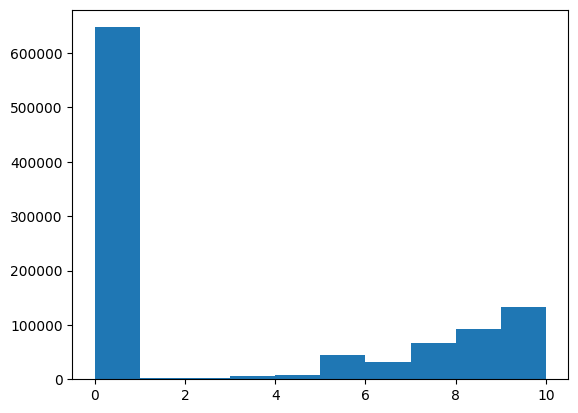

In [6]:
plt.hist(ratings['rating'])
plt.show()

In [7]:
trim_ratings = ratings.filter(['user_id','isbn','rating','book_title'])
#trim_ratings['rating'] = trim_ratings['rating'].astype(float)
#trim_ratings['rating'] = np.where(trim_ratings['rating']==0, np.NaN, trim_ratings['rating'])
display(trim_ratings.head(2))

,user_id,isbn,rating,book_title
0,2,0195153448,0,Classical Mythology
1,8,0002005018,5,Clara Callan


In [8]:
dls = CollabDataLoaders.from_df(trim_ratings,user_nam='user_id',item_name='book_title',bs=64)
dls.show_batch()

,user_id,book_title,rating
0,174830,The Coachman Rat,0
1,239413,The Shadow of Desire,7
2,119567,Fiction: A Longman Pocket Anthology (Longman Pocket Anthology Series),7
3,29135,His Share of Glory: The Complete Short Science Fiction of C.M. Kornbluth,0
4,11676,Nightshade,9
5,227539,Die grÃ?Â¶sste Show jenseits der Welt.,0
6,170229,A Century of Shoes: Icons of Style in the 20th Century,0
7,11676,Hard Times (Bantam Classics),6
8,193063,The End of Nature,0
9,40012,The gobbler,0


In [9]:
def create_params(size):
    return nn.Parameter(zeros(*size).normal_(0,0.01))

class DotProductBias(nn.Module):
    def __init__(self, n_users, n_books, n_factors, y_range=(0, 10.5)):
        super().__init__()
        #Readers
        self.user_factors = create_params((n_users, n_factors))
        self.user_bias = create_params([n_users])
        #Books
        self.book_factors = create_params((n_books,n_factors))
        self.book_bias = create_params([n_books])
        self.y_range = y_range
        self.print_once = True
        
    def forward(self, x):
        """
        Explanation of following line:
        pytorch expects a batch to be "x" in the forward function. the x has many rows but only two columns: 0, 1.
        0 = the user id's for that item
        1 = the movie id's for that item

        then, we use those id's to index into our user_factors and book_factors. 
        so it still returns the same rows of each batch, but the corresponding factors for them per user and books
        """
        users = self.user_factors[x[:,0]]
        if self.print_once:
            print(users.shape)
            print(users)
            
        books = self.book_factors[x[:,1]]
        if self.print_once:
            print(books.shape)
            print(books)
        self.print_once = False
        result = (users * books).sum(dim=1)
        result += self.user_bias[x[:,0]] + self.book_bias[x[:,1]]
        return(sigmoid_range(result, *self.y_range))

In [10]:
n_users = len(dls.classes['user_id'])
n_books = len(dls.classes['book_title'])
model = DotProductBias(n_users, n_books, n_factors=50)
print(model.user_factors[0])
print(model.book_factors[0])

tensor([-1.1837e-02,  1.3902e-02, -1.6038e-02,  4.3777e-03, -2.0383e-04,
        -1.7636e-03,  4.0863e-03, -3.5677e-03,  8.5326e-03, -1.1618e-02,
         5.2737e-03,  3.0282e-03, -1.7029e-02, -3.1605e-05, -6.0174e-04,
         1.4634e-02,  1.1740e-03,  1.5831e-03,  6.6569e-05, -1.3079e-02,
         8.4160e-03,  3.5015e-03,  5.0047e-03, -1.2653e-02,  7.7043e-03,
         1.2540e-02, -7.4745e-03, -1.0268e-02, -9.2423e-03, -5.0809e-03,
         2.6778e-03, -8.0919e-03, -4.1383e-03, -1.3498e-02,  1.1778e-02,
        -6.1031e-04,  6.1227e-04,  3.6291e-03, -7.7699e-04, -5.0264e-03,
        -1.0597e-02, -7.6003e-03,  1.8172e-02, -5.4935e-03,  8.1222e-03,
        -1.1682e-02,  1.5006e-02, -1.4934e-02, -4.8122e-03, -1.0999e-02],
       grad_fn=<SelectBackward0>)
tensor([-0.0115,  0.0107, -0.0089,  0.0199, -0.0055,  0.0046, -0.0078,  0.0069,
        -0.0220,  0.0008,  0.0097,  0.0074, -0.0104,  0.0073, -0.0021,  0.0043,
        -0.0140, -0.0055,  0.0004,  0.0075,  0.0076,  0.0060,  0.0209, -0.0

In [22]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(6, 1e-0, wd=0.1)

epoch,train_loss,valid_loss,time
0,18.071623,17.705984,01:40
1,18.198248,18.339552,01:41
2,17.329199,18.021574,01:41
3,17.148928,16.998671,01:41
4,15.518782,15.897316,01:41
5,12.929073,13.728774,01:40


In [23]:
book_bias = learn.model.book_bias.squeeze()
print(book_bias.shape)

idxs = book_bias.argsort()[:5]
print(idxs)

display([dls.classes['book_title'][i] for i in idxs])

book_bias = learn.model.book_bias.squeeze()
idxs = book_bias.argsort()[-5:]
display([dls.classes['book_title'][i] for i in idxs])

torch.Size([241091])
tensor([234965,  54925,  64269, 193892, 209255], device='cuda:0')


['Wild Animus',
 'Dragon Tears',
 'False Memory',
 'The King of Torts',
 'The Sum of All Fears (Jack Ryan Novels)']

['Hostage',
 'Haroun and the Sea of Stories',
 'Harry Potter and the Prisoner of Azkaban (Book 3)',
 'On a Pale Horse (Incarnations of Immortality, Bk. 1)',
 "Harry Potter and the Sorcerer's Stone (Book 1)"]

# Using FastAI

In [24]:
learn = collab_learner(dls, n_factors=100, y_range=(0,10.5))
learn.fit_one_cycle(6, 1e-0, wd=0.1)

epoch,train_loss,valid_loss,time
0,17.879139,17.928345,02:39
1,18.456442,18.196030,02:40
2,18.129929,17.955797,02:40
3,17.524210,17.215584,02:39
4,16.329733,16.475637,02:42
5,12.358016,13.703984,02:38


In [30]:
book_bias = learn.model.i_bias.weight.squeeze()
idxs = book_bias.argsort(descending=True)[:5]
[dls.classes['book_title'][i] for i in idxs]

book_factors = learn.model.i_weight.weight
idx = dls.classes['book_title']
print(type(idx))
idx = idx.o2i['Harry Potter and the Prisoner of Azkaban (Book 3)']
distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['book_title'][idx]

<class 'fastai.data.transforms.CategoryMap'>


'Garzanti - Gli Elefanti: Notte Della Cometa'

In [31]:
embs = get_emb_sz(dls)
print(embs)

[(81344, 600), (241091, 600)]


In [32]:
class CollabNN(nn.Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        super().__init__()
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
    
    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return(sigmoid_range(x, *self.y_range))

In [ ]:
model = CollabNN(*embs)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(6, 1e-0, wd=0.1)

epoch,train_loss,valid_loss,time
0,14.761316,15.110804,12:25
1,14.592128,14.857658,12:25
2,14.768010,14.884907,12:25
3,14.708531,14.904355,12:26
